In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [4]:
#Deelap 모델 생성

MODEL_DIR = os.getenv('HOME')+'/aiffel/human_segmentation'
MODEL_FILE = os.path.join(MODEL_DIR, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

if not os.path.exists(MODEL_FILE):
    # PixelLib가 제공하는 모델의 url입니다
    MODEL_URL = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

    # 다운로드를 시작합니다
    urllib.request.urlretrieve(MODEL_URL, MODEL_FILE)

In [5]:
# 세그멘테이션 모델 생성
MODEL = semantic_segmentation()
MODEL.load_pascalvoc_model(MODEL_FILE)

In [6]:
#PASCAL VOC 데이터 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [7]:
# seg_color 반환 함수
def get_colormap(label_name):
    # 아래 코드를 이해하지 않아도 좋습니다
    # PixelLib에서 그대로 가져온 코드입니다
    # 주목해야 할 것은 생상 코드 결과물이예요!
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    # colormap[:20]

    index = LABEL_NAMES.index(label_name)  # 데이터 라벨 인덱스
    seg_color = colormap[index].tolist()  # BGR
    seg_color = seg_color[::-1]  # BGR2RGB
    return seg_color  # RGB

matplotlib 크기 줄이는 방법
- plt.figure(figsize=(w,h))
  - 이미지 그리기 전 설정
  - default_figsize = (6.4, 4.8)
- fig.set_size_inches(w,h)
  - 이미지 그려진 후 설정
- plt.rcParams["figure.figsize"] = (w,h)

In [8]:
# 이미지 1개 그리기
def draw_img(img, img_title='', cmap=None):
    print(img.shape)

    # plt.figure(figsize=(12,12))
    plt.imshow(img, cmap)
    plt.title(img_title)
    plt.rc('axes', titlesize=20)
    plt.axis('off')

    plt.show()
    

# 이미지 2개 그리기
def draw_imgs(img_1, img_2, img_1_title='', img_2_title=''):
    plt.figure(figsize=(12,8))

    plt.subplot(211)
    plt.imshow(img_1)
    plt.title(img_1_title)
    plt.rc('axes', titlesize=20)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(img_2)
    plt.title(img_2_title)
    plt.rc('axes', titlesize=20)
    plt.axis('off')

    plt.show()

1. 인물사진 
 - 이미지확인

In [9]:
PERSON_IMG_PATH = os.getenv('HOME')+'/aiffel/human_segmentation/model.png'
PERSON_IMG_ORIG = cv2.imread(PERSON_IMG_PATH)

(596, 922, 3)


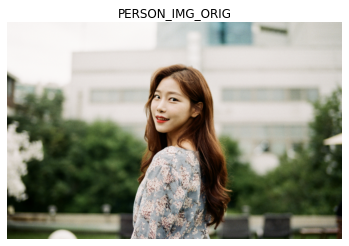

In [10]:
draw_img(cv2.cvtColor(PERSON_IMG_ORIG, cv2.COLOR_BGR2RGB), 'PERSON_IMG_ORIG')

- DeepLab 모델에 이미지 입력 후 출력 확인

In [11]:
# 모델에 이미지 입력
PERSON_SEGVALUES, PERSON_OUTPUT = MODEL.segmentAsPascalvoc(PERSON_IMG_PATH)

# 영역 검출된 클래스 출력
for class_id in PERSON_SEGVALUES['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


(596, 922, 3)


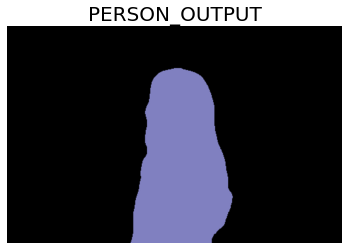

In [12]:
# 모델 출력값 확인
draw_img(PERSON_OUTPUT, 'PERSON_OUTPUT')

- seg_color로만 이루어진 마스크 생성

(596, 922)


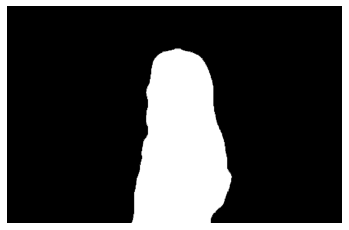

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_color = get_colormap('person')
person_seg_map = np.all(PERSON_OUTPUT==seg_color, axis=-1)

draw_img(person_seg_map, cmap='gray')

- 원본 이미지와 겹쳐서 세그멘테이션 적용 확인

(596, 922, 3)


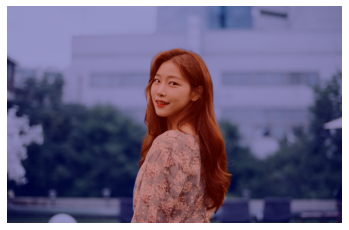

In [14]:
person_img_show = PERSON_IMG_ORIG.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
person_img_mask = person_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
person_color_mask = cv2.applyColorMap(person_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
person_img_show = cv2.addWeighted(person_img_show, 0.6, person_color_mask, 0.4, 0.0)

draw_img(cv2.cvtColor(person_img_show, cv2.COLOR_BGR2RGB))

- 이미지 흐리게 만들기
  - cv2.blur(img, blurring_kernel_size)
    - OpenCV의 blur 함수는 평균 블러링(Averaging Blurring)이다.

(596, 922, 3)


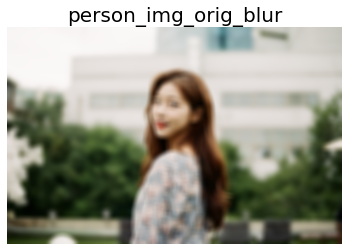

In [15]:
# blurring kernel size = (17,17)
person_img_orig_blur = cv2.blur(PERSON_IMG_ORIG, (17,17))

draw_img(cv2.cvtColor(person_img_orig_blur, cv2.COLOR_BGR2RGB), 'person_img_orig_blur')

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
  - 색이 없으면 검게 보이고(0) 색이 있으면 흰색(1)으로 표현됨
    - cv2.bitwise_not(img): 색 반전 => 0은 1로, 1은 0으로 변경
    - cv2.bitwise_and(img_1, img_2): 모두 흰색(1)인 부분만 1로 나타남

(596, 922, 3)


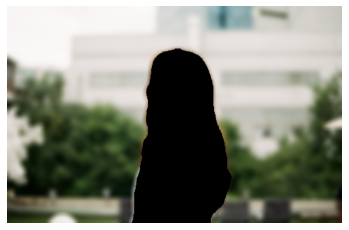

In [16]:
person_img_mask_color = cv2.cvtColor(person_img_mask, cv2.COLOR_GRAY2BGR)
person_img_bg_mask = cv2.bitwise_not(person_img_mask_color)
person_img_bg_blur = cv2.bitwise_and(person_img_orig_blur, person_img_bg_mask)

draw_img(cv2.cvtColor(person_img_bg_blur, cv2.COLOR_BGR2RGB))

- 배경 이미지와 사람 이미지 합치기
  - numpy.where(condition,[x,y])
    - 입력 조건을 충족하는 배열의 색인을 생성
    - 조건이 True이면 출력에 x의 요소가 포함되고, 그렇지 않으면 출력에 y의 요소가 포함된다.

(596, 922, 3)


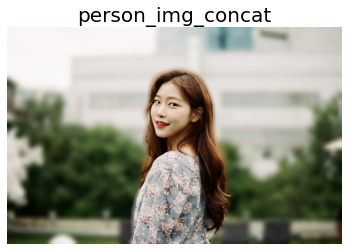

In [17]:
person_img_concat = np.where(person_img_mask_color==255, PERSON_IMG_ORIG, person_img_bg_blur)

draw_img(cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB), 'person_img_concat')

- 이미지 처리 결과 저장

In [21]:
# cf. plt.savefig() 는 plt.show() 직전에 해야 처리가 끝난 이미지 저장이 제대로 된다.
# plt.savefig('image.png', bbox_inches='tight',pad_inches = 0) 로 저장했더니 공백 및 테두리 숨기기가 제대로 안 됨 => plt.imsave('image.png', img)를 사용함
plt.imsave(os.getenv('HOME')+'/aiffel/human_segmentation/person_blur.png', cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB))

- blur 적용 전후 비교

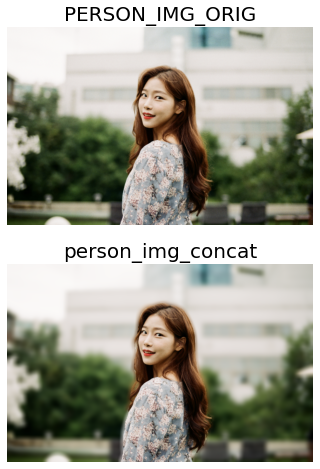

In [22]:
draw_imgs(cv2.cvtColor(PERSON_IMG_ORIG, cv2.COLOR_BGR2RGB), cv2.cvtColor(person_img_concat, cv2.COLOR_BGR2RGB), 'PERSON_IMG_ORIG', 'person_img_concat')

# 2. 동물사진

- 이미지확인

In [24]:
ANIMAL_IMG_PATH = os.getenv('HOME')+'/aiffel/human_segmentation/animal.png'
ANIMAL_IMG_ORIG = cv2.imread(ANIMAL_IMG_PATH) 

(486, 807, 3)


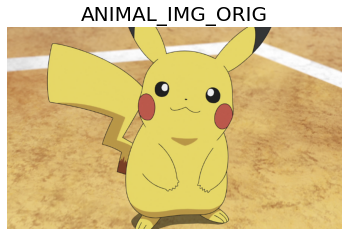

In [26]:
draw_img(cv2.cvtColor(ANIMAL_IMG_ORIG, cv2.COLOR_BGR2RGB), 'ANIMAL_IMG_ORIG')

- DeepLab 모델에 이미지 입력 후 출력 확인

In [28]:
# 모델에 이미지 입력
ANIMAL_SEGVALUES, ANIMAL_OUTPUT = MODEL.segmentAsPascalvoc(ANIMAL_IMG_PATH)

In [29]:
# 영역 검출된 클래스 출력
for class_id in ANIMAL_SEGVALUES['class_ids']:
    print(LABEL_NAMES[class_id])

background


- 포켓몬사진은 동물로 인식을 못하는건가? 동물사진으로 다시해보자

In [30]:
CAT_IMG_PATH = os.getenv('HOME')+'/aiffel/human_segmentation/CAT.png'
CAT_IMG_ORIG = cv2.imread(CAT_IMG_PATH) 

(495, 692, 3)


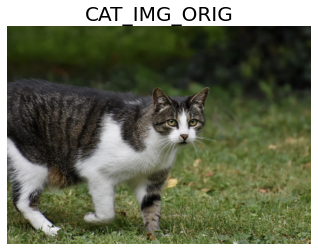

In [31]:
draw_img(cv2.cvtColor(CAT_IMG_ORIG, cv2.COLOR_BGR2RGB), 'CAT_IMG_ORIG')

In [32]:
# 모델에 이미지 입력
CAT_SEGVALUES, CAT_OUTPUT = MODEL.segmentAsPascalvoc(CAT_IMG_PATH)

In [33]:
# 영역 검출된 클래스 출력
for class_id in CAT_SEGVALUES['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


(495, 692, 3)


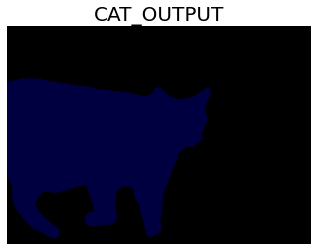

In [34]:
# 모델 출력값 확인
draw_img(CAT_OUTPUT, 'CAT_OUTPUT')

(495, 692)


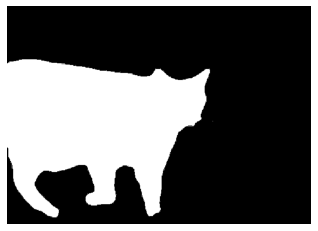

In [35]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_color = get_colormap('cat')
cat_seg_map = np.all(CAT_OUTPUT==seg_color, axis=-1)

draw_img(cat_seg_map, cmap='gray')

- 원본이미지와 겹쳐서 세그멘터이션 확인

(495, 692, 3)


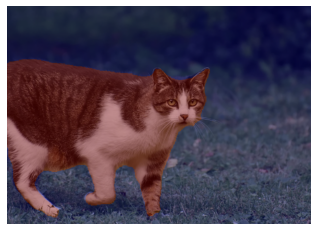

In [36]:
cat_img_show = CAT_IMG_ORIG.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

draw_img(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))

- 이미지 흐리게 만들기
  - cv2.blur(img, blurring_kernel_size)
    - OpenCV의 blur 함수는 평균 블러링(Averaging Blurring)이다.

(495, 692, 3)


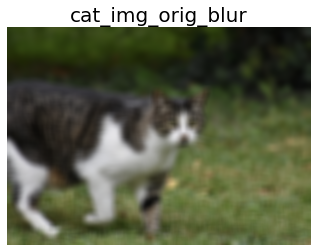

In [37]:
# blurring kernel size = (17,17)
cat_img_orig_blur = cv2.blur(CAT_IMG_ORIG, (17,17))

draw_img(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB), 'cat_img_orig_blur')

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
  - 색이 없으면 검게 보이고(0) 색이 있으면 흰색(1)으로 표현됨
    - cv2.bitwise_not(img): 색 반전 => 0은 1로, 1은 0으로 변경
    - cv2.bitwise_and(img_1, img_2): 모두 흰색(1)인 부분만 1로 나타남

(495, 692, 3)


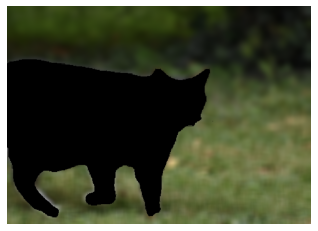

In [38]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)

draw_img(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))

- 배경 이미지와 고양이 이미지 합치기
  - numpy.where(condition,[x,y])
    - 입력 조건을 충족하는 배열의 색인을 생성
    - 조건이 True이면 출력에 x의 요소가 포함되고, 그렇지 않으면 출력에 y의 요소가 포함된다.

(495, 692, 3)


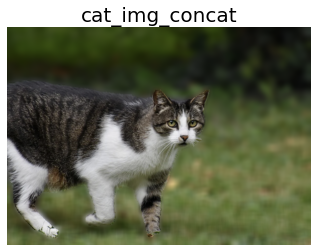

In [39]:
cat_img_concat = np.where(cat_img_mask_color==255, CAT_IMG_ORIG, cat_img_bg_blur)

draw_img(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB), 'cat_img_concat')

In [40]:
# cf. plt.savefig() 는 plt.show() 직전에 해야 처리가 끝난 이미지 저장이 제대로 된다.
# plt.savefig('image.png', bbox_inches='tight',pad_inches = 0) 로는 공백 및 테두리 숨기기가 제대로 안 됐기에 plt.imsave('image.png', img)를 사용함
plt.imsave(os.getenv('HOME')+'/aiffel/human_segmentation/CAT_blur.png', cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))

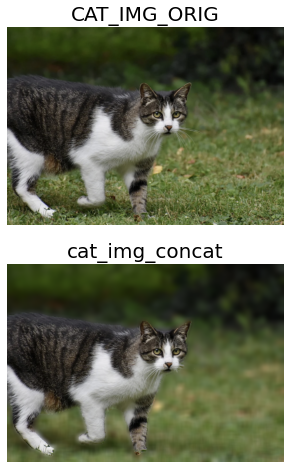

In [41]:
draw_imgs(cv2.cvtColor(CAT_IMG_ORIG, cv2.COLOR_BGR2RGB), cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB), 'CAT_IMG_ORIG', 'cat_img_concat')

# 3 배경전환 크로마키

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
1. 코랩에서 할떄 모듈 설치하고 디버깅하느냐고 시간 다뺐김. 결국 커널에서 진행

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
피카츄는 왜 동물로 인식이 안되는가?